In [1]:


# 📦 LIBRARIES
import mysql.connector
from faker import Faker
from random import randint, choice
from datetime import timedelta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor, XGBClassifier
import joblib




In [2]:
# -----------------------------
# 1️⃣ DATABASE CONNECTION + DATA EXPANSION
# -----------------------------
username = 'root'
password = '2004'
host = 'localhost'
port = '3306'
database = 'invoice_predictor'

conn = mysql.connector.connect(host=host, user=username, password=password, database=database)
cursor = conn.cursor()
fake = Faker()

# Insert 500 customers
total_customers = 500
total_invoices = 5000

for _ in range(total_customers):
    cursor.execute("""
        INSERT INTO customers (customer_name, industry, region, credit_score)
        VALUES (%s, %s, %s, %s)
    """, (fake.company(), fake.job(), fake.state(), randint(400, 850)))
conn.commit()

cursor.execute("SELECT customer_id FROM customers")
customer_ids = [row[0] for row in cursor.fetchall()]

for _ in range(total_invoices):
    cust_id = choice(customer_ids)
    amount = round(fake.pyfloat(left_digits=5, right_digits=2, positive=True), 2)
    issue_date = fake.date_between(start_date='-1y', end_date='today')
    due_date = issue_date + timedelta(days=choice([15, 30, 45, 60]))
    delay = choice([0, randint(1, 15), randint(16, 45), randint(46, 90)])
    paid_date = due_date + timedelta(days=delay)
    paid_amount = amount if delay < 80 else round(amount * 0.95, 2)

    cursor.execute("""
        INSERT INTO invoices (customer_id, invoice_amount, issue_date, due_date)
        VALUES (%s, %s, %s, %s)
    """, (cust_id, amount, issue_date, due_date))
    invoice_id = cursor.lastrowid

    cursor.execute("""
        INSERT INTO payments (invoice_id, paid_date, payment_amount)
        VALUES (%s, %s, %s)
    """, (invoice_id, paid_date, paid_amount))

conn.commit()
cursor.close()
conn.close()
print("✅ Data inserted into MySQL!")

# -----------------------------

✅ Data inserted into MySQL!


In [3]:

# 2️⃣ LOAD DATASET
# -----------------------------
connection_str = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_str)

query = """
SELECT c.customer_id, c.customer_name, c.region, c.credit_score,
       i.invoice_id, i.invoice_amount, i.issue_date, i.due_date,
       p.paid_date,
       DATEDIFF(p.paid_date, i.due_date) AS delay_days,
       CASE WHEN DATEDIFF(p.paid_date, i.due_date) > 0 THEN 1 ELSE 0 END AS is_delayed
FROM customers c
JOIN invoices i ON c.customer_id = i.customer_id
JOIN payments p ON i.invoice_id = p.invoice_id;
"""

df = pd.read_sql(query, engine)
df[['issue_date', 'due_date', 'paid_date']] = df[['issue_date', 'due_date', 'paid_date']].apply(pd.to_datetime)
df['delay_days'] = df['delay_days'].apply(lambda x: max(0, x))

# -----------------------------

In [4]:

# 3️⃣ FEATURE ENGINEERING
# -----------------------------
df['delay_bucket'] = pd.cut(df['delay_days'], bins=[-1,15,30,45,60,200], labels=['0-15','16-30','31-45','46-60','60+'])
df['issue_day'] = df['issue_date'].dt.day
df['issue_month'] = df['issue_date'].dt.month
df['due_day'] = df['due_date'].dt.day
df['due_month'] = df['due_date'].dt.month
df['paid_month'] = df['paid_date'].dt.month
df['days_to_pay'] = (df['paid_date'] - df['issue_date']).dt.days
df['due_duration'] = (df['due_date'] - df['issue_date']).dt.days
df['invoice_month'] = df['issue_date'].dt.month


In [5]:

# -----------------------------
# 4️⃣ EDA REPORT 
# -----------------------------
import sweetviz as sv
sv.analyze(df).show_html("invoice_sweetviz_report.html")

# -----------------------------

                                             |          | [  0%]   00:00 -> (? left)

Report invoice_sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


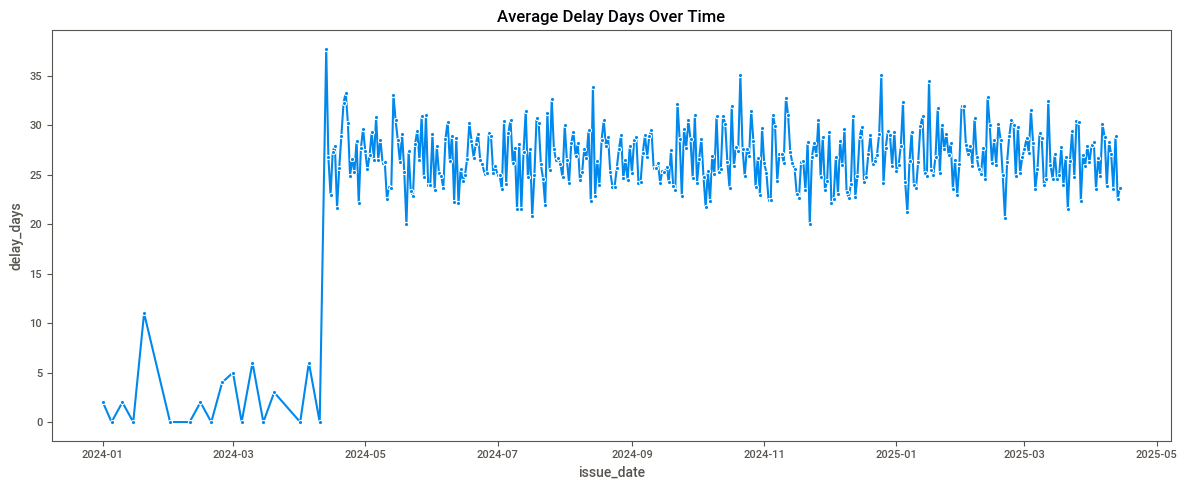

In [6]:
# 5️⃣ TIME-BASED VISUAL
# -----------------------------
delay_trend = df.groupby('issue_date')['delay_days'].mean().reset_index()
plt.figure(figsize=(12, 5))
sns.lineplot(data=delay_trend, x='issue_date', y='delay_days', marker='o')
plt.title("Average Delay Days Over Time")
plt.tight_layout()
plt.show()


In [7]:
# ====================================================
#  IMPORTS
# ====================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)
from xgboost import XGBRegressor, XGBClassifier, plot_importance


In [8]:
# ====================================================
#  DATA SPLIT FOR REGRESSION & CLASSIFICATION
# ====================================================

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['region', 'customer_name'], drop_first=True)

# Select features
features = ['invoice_amount', 'credit_score', 'days_to_pay', 'due_duration', 'invoice_month'] + \
           [col for col in df_encoded.columns if col.startswith('region_') or col.startswith('customer_name_')]
X = df_encoded[features]

# REGRESSION target
y_reg = df_encoded['delay_days']

# CLASSIFICATION target
y_class = df_encoded['is_delayed']

# Train-test splits
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.3, random_state=42)


In [9]:
# ====================================================
#  BASE REGRESSION MODELS
# ====================================================
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_reg, y_train_reg)
    preds = model.predict(X_test_reg)

    mae = round(mean_absolute_error(y_test_reg, preds), 2)
    rmse = round(mean_squared_error(y_test_reg, preds, squared=False), 2)
    r2 = round(r2_score(y_test_reg, preds), 2)

    print(f"\n\U0001F4CA {name} Performance:")
    print("MAE:", mae, "RMSE:", rmse, "R²:", r2)

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2 Score": r2})



📊 Random Forest Performance:
MAE: 0.0 RMSE: 0.01 R²: 1.0

📊 Linear Regression Performance:
MAE: 0.0 RMSE: 0.1 R²: 1.0

📊 XGBoost Performance:
MAE: 0.08 RMSE: 0.14 R²: 1.0


In [10]:
# TUNED XGBOOST REGRESSOR
# ====================================================
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_reg = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=xgb_params,
    n_iter=10,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
xgb_reg.fit(X_train_reg, y_train_reg)

xgb_best = xgb_reg.best_estimator_
xgb_preds = xgb_best.predict(X_test_reg)

xgb_mae = round(mean_absolute_error(y_test_reg, xgb_preds), 2)
xgb_rmse = round(mean_squared_error(y_test_reg, xgb_preds, squared=False), 2)
xgb_r2 = round(r2_score(y_test_reg, xgb_preds), 2)

print("\n\U0001F527 Tuned XGBoost Regressor Performance:")
print("MAE:", xgb_mae, "RMSE:", xgb_rmse, "R²:", xgb_r2)

results.append({"Model": "Tuned XGBoost Regressor", "MAE": xgb_mae, "RMSE": xgb_rmse, "R2 Score": xgb_r2})


Fitting 3 folds for each of 10 candidates, totalling 30 fits

🔧 Tuned XGBoost Regressor Performance:
MAE: 0.0 RMSE: 0.01 R²: 1.0


In [11]:
# ====================================================
#  REGRESSION PIPELINES
# ====================================================
xgb_pipeline = Pipeline(steps=[('model', XGBRegressor(random_state=42))])
xgb_pipeline.fit(X_train_reg, y_train_reg)
xgb_preds_pipe = xgb_pipeline.predict(X_test_reg)

print("\nXGB Pipeline Performance:")
print("MAE:", round(mean_absolute_error(y_test_reg, xgb_preds_pipe), 2))
print("RMSE:", round(mean_squared_error(y_test_reg, xgb_preds_pipe, squared=False), 2))
print("R²:", round(r2_score(y_test_reg, xgb_preds_pipe), 2))

rf_pipeline = Pipeline(steps=[('model', RandomForestRegressor(random_state=42))])
rf_pipeline.fit(X_train_reg, y_train_reg)
rf_preds_pipe = rf_pipeline.predict(X_test_reg)

print("\nRandom Forest Pipeline Performance:")
print("MAE:", round(mean_absolute_error(y_test_reg, rf_preds_pipe), 2))
print("RMSE:", round(mean_squared_error(y_test_reg, rf_preds_pipe, squared=False), 2))
print("R²:", round(r2_score(y_test_reg, rf_preds_pipe), 2))



XGB Pipeline Performance:
MAE: 0.08
RMSE: 0.14
R²: 1.0

Random Forest Pipeline Performance:
MAE: 0.0
RMSE: 0.01
R²: 1.0


In [12]:
# ====================================================
#  LOGISTIC REGRESSION CLASSIFIER
# ====================================================
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

log_acc = round(accuracy_score(y_test, y_pred_log), 2)
print("\n\U0001F4CA Logistic Regression Accuracy:", log_acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

results.append({"Model": "Logistic Regression", "MAE": None, "RMSE": None, "R2 Score": log_acc})



C:\Users\saanv\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 Logistic Regression Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2654
           1       1.00      1.00      1.00      7854

    accuracy                           1.00     10508
   macro avg       1.00      1.00      1.00     10508
weighted avg       1.00      1.00      1.00     10508


Confusion Matrix:
 [[2654    0]
 [   0 7854]]


In [13]:
# ====================================================
#  TUNED RANDOM FOREST CLASSIFIER
# ====================================================
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# 🎛️ Hyperparameter grid for classification
rf_clf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}

# 🔍 RandomizedSearchCV for classifier
rf_clf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_clf_params,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)

# 🧠 Train classifier on classification data
rf_clf_search.fit(X_train, y_train)
rf_clf_best = rf_clf_search.best_estimator_

# ✅ Predict & Evaluate
y_pred_clf = rf_clf_best.predict(X_test)

clf_acc = round(accuracy_score(y_test, y_pred_clf), 2)
print("\n🎯 Tuned Random Forest Classifier Accuracy:", clf_acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_clf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_clf))

# 📊 Add to results table
results.append({
    "Model": "Tuned Random Forest Classifier",
    "MAE": None,
    "RMSE": None,
    "R2 Score": clf_acc  # using accuracy as score
})



🎯 Tuned Random Forest Classifier Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2654
           1       1.00      1.00      1.00      7854

    accuracy                           1.00     10508
   macro avg       1.00      1.00      1.00     10508
weighted avg       1.00      1.00      1.00     10508


Confusion Matrix:
 [[2651    3]
 [  14 7840]]


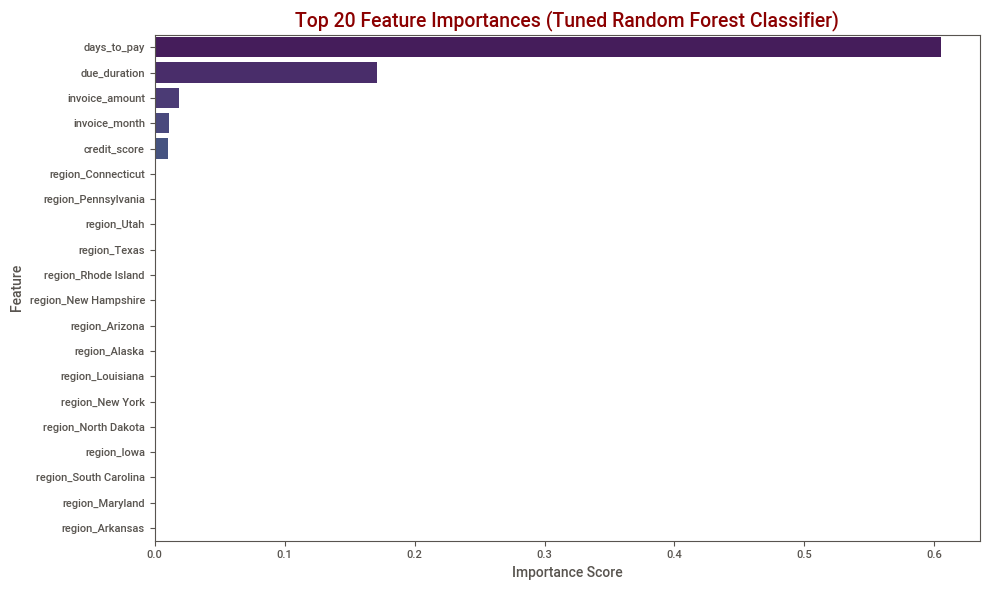

In [16]:
# ====================================================
#  RANDOM FOREST FEATURE IMPORTANCE (Tuned Classifier)
# ====================================================
feature_importance = pd.Series(rf_clf_best.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 20 Feature Importances (Tuned Random Forest Classifier)', fontsize=14, color='darkred')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


C:\Users\saanv\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classifier Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2654
           1       1.00      1.00      1.00      7854

    accuracy                           1.00     10508
   macro avg       1.00      1.00      1.00     10508
weighted avg       1.00      1.00      1.00     10508


Confusion Matrix:
 [[2654    0]
 [   0 7854]]


<Figure size 1000x600 with 0 Axes>

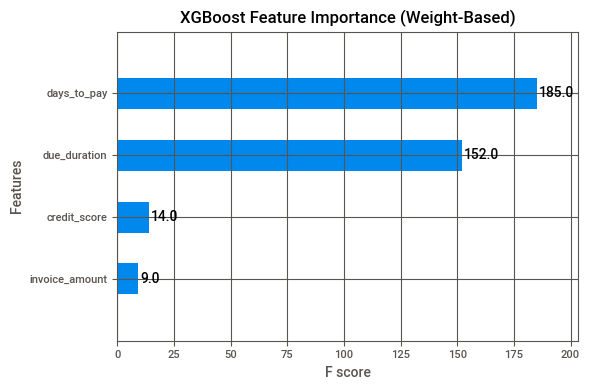

<Figure size 1000x600 with 0 Axes>

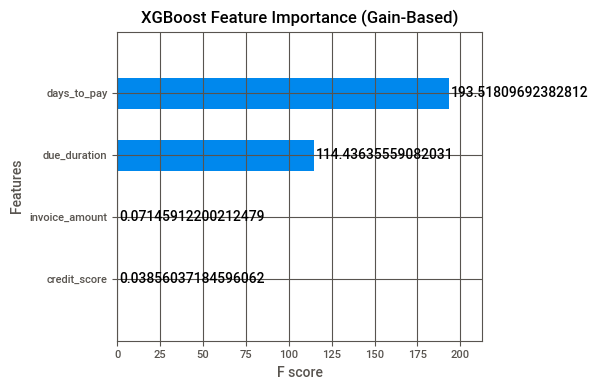

In [14]:
 # XGBOOST CLASSIFIER + FEATURE IMPORTANCE
# ====================================================
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

xgb_acc = round(accuracy_score(y_test, y_pred_xgb), 2)
print("\nXGBoost Classifier Accuracy:", xgb_acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

results.append({"Model": "XGBoost Classifier", "MAE": None, "RMSE": None, "R2 Score": xgb_acc})

plt.figure(figsize=(10, 6))
plot_importance(xgb_clf, importance_type='weight', height=0.5)
plt.title("XGBoost Feature Importance (Weight-Based)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plot_importance(xgb_clf, importance_type='gain', height=0.5)
plt.title("XGBoost Feature Importance (Gain-Based)")
plt.tight_layout()
plt.show()


In [17]:

# ====================================================
# FINAL RESULTS TABLE
# ====================================================
pd.DataFrame(results)


,Model,MAE,RMSE,R2 Score
0,Random Forest,0.00,0.01,1.0
1,Linear Regression,0.00,0.10,1.0
2,XGBoost,0.08,0.14,1.0
3,Tuned XGBoost Regressor,0.00,0.01,1.0
4,Logistic Regression,NaN,NaN,1.0
5,Tuned Random Forest Classifier,NaN,NaN,1.0
6,XGBoost Classifier,NaN,NaN,1.0


In [18]:
# FINAL PREDICTION & EXPORT
# -----------------------------
final_model = xgb_best  # choose best model from training

# 📌 Define delay_bucket function
def delay_bucket(d):
    if d <= 15:
        return '0-15'
    elif d <= 30:
        return '16-30'
    elif d <= 45:
        return '31-45'
    elif d <= 60:
        return '46-60'
    else:
        return '60+'

# 🔮 Predict on full dataset
df['predicted_delay'] = final_model.predict(X)
df['predicted_delay'] = df['predicted_delay'].apply(lambda x: max(0, round(x)))  # Round & avoid negatives
df['predicted_clear_date'] = df['due_date'] + pd.to_timedelta(df['predicted_delay'], unit='D')
df['aging_bucket'] = df['predicted_delay'].apply(delay_bucket)

# 📤 Export results
export_cols = ['customer_id', 'customer_name', 'invoice_id', 'invoice_amount', 'issue_date', 'due_date',
               'predicted_delay', 'predicted_clear_date', 'aging_bucket']

df[export_cols].to_csv("invoice_delay_predictions.csv", index=False)
pd.DataFrame(results).to_csv("model_comparison_table.csv", index=False)

print("✅ Predictions and model results exported successfully!")
# Optional: View outputs inside notebook
from IPython.display import display

print("📦 Top 5 Predicted Invoices:")
display(df[export_cols].head())

print("\n📊 Model Comparison Table:")
display(pd.DataFrame(results))



✅ Predictions and model results exported successfully!
📦 Top 5 Predicted Invoices:


,customer_id,customer_name,invoice_id,invoice_amount,issue_date,due_date,predicted_delay,predicted_clear_date,aging_bucket
0,1,Acme Corp,1,15000.0,2024-01-01,2024-01-31,2,2024-02-02,0-15
1,1,Acme Corp,6,18000.0,2024-02-01,2024-03-02,0,2024-03-02,0-15
2,1,Acme Corp,11,19000.0,2024-03-01,2024-03-31,5,2024-04-05,0-15
3,1,Acme Corp,16,17000.0,2024-04-01,2024-05-01,0,2024-05-01,0-15
4,1,Acme Corp,21,16000.0,2024-05-01,2024-05-31,1,2024-06-01,0-15



📊 Model Comparison Table:


,Model,MAE,RMSE,R2 Score
0,Random Forest,0.00,0.01,1.0
1,Linear Regression,0.00,0.10,1.0
2,XGBoost,0.08,0.14,1.0
3,Tuned XGBoost Regressor,0.00,0.01,1.0
4,Logistic Regression,NaN,NaN,1.0
5,Tuned Random Forest Classifier,NaN,NaN,1.0
6,XGBoost Classifier,NaN,NaN,1.0


In [61]:
# 💰 Financial Impact Analysis
df['delay_risk_amount'] = df['invoice_amount'] * (df['predicted_delay'] > 30)
total_risk = df['delay_risk_amount'].sum()

print(f"💰 Estimated Revenue at Risk due to delays: ₹{total_risk:,.2f}")


💰 Estimated Revenue at Risk due to delays: ₹660,394,800.35


,predicted_delay,invoice_amount,credit_score
risk_cluster,,,
0,26.632198,50227.976055,621.518705
1,27.056298,16780.097683,623.686375
2,26.653839,83468.367629,621.365969


C:\Users\saanv\AppData\Local\Temp\ipykernel_27948\1999396011.py:44: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
C:\Users\saanv\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


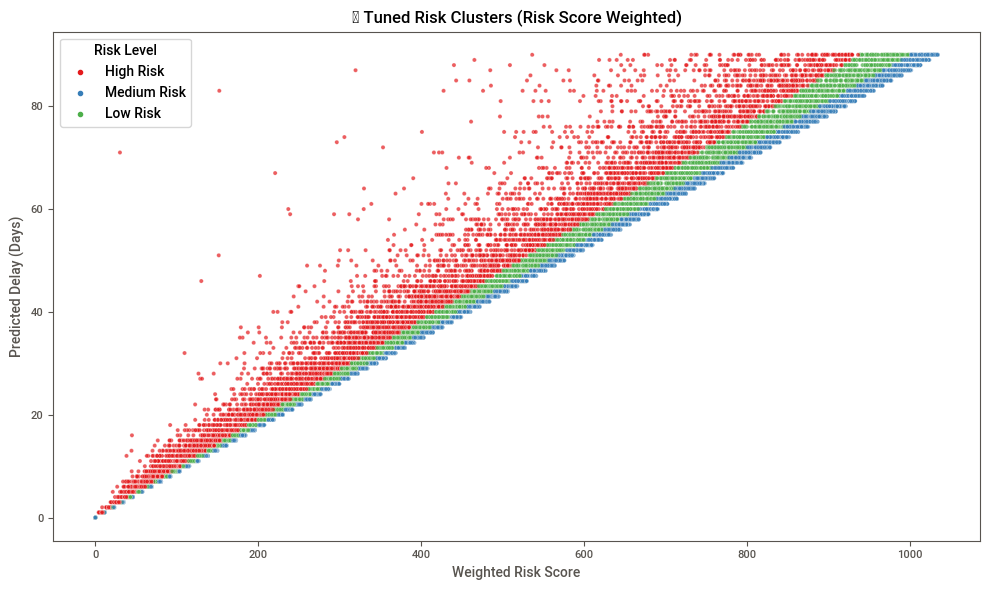

In [64]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Create weighted risk score matrix
df['risk_score'] = df['predicted_delay'] * np.log(df['invoice_amount'] + 1)

# 2️⃣ Input matrix for clustering (include log-amount impact)
risk_data = df[['risk_score', 'invoice_amount', 'credit_score']]

# 3️⃣ KMeans clustering (3 clusters: Low, Med, High risk)
kmeans = KMeans(n_clusters=3, random_state=42)
df['risk_cluster'] = kmeans.fit_predict(risk_data)

# 4️⃣ Analyze the clusters
cluster_stats = df.groupby('risk_cluster')[['predicted_delay', 'invoice_amount', 'credit_score']].mean()
display(cluster_stats)

# 5️⃣ Post-label clusters 
risk_map = {
    cluster_stats['predicted_delay'].idxmax(): 'High Risk',
    cluster_stats['predicted_delay'].idxmin(): 'Low Risk'
}
# Whatever is left → Medium Risk
remaining = list(set([0, 1, 2]) - set(risk_map.keys()))
risk_map[remaining[0]] = 'Medium Risk'

df['risk_label'] = df['risk_cluster'].map(risk_map)

# 6️⃣ Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df,
                x='risk_score',
                y='predicted_delay',
                hue='risk_label',
                palette='Set1',
                alpha=0.7)
plt.title("🔥 Tuned Risk Clusters (Risk Score Weighted)")
plt.xlabel("Weighted Risk Score")
plt.ylabel("Predicted Delay (Days)")
plt.legend(title='Risk Level')
plt.tight_layout()
plt.show()
# How do we group the invoices into meaningful risk profiles for business decision making?


In [26]:
pip install shap --user


Note: you may need to restart the kernel to use updated packages.


PermutationExplainer explainer: 101it [06:29,  3.97s/it]                         


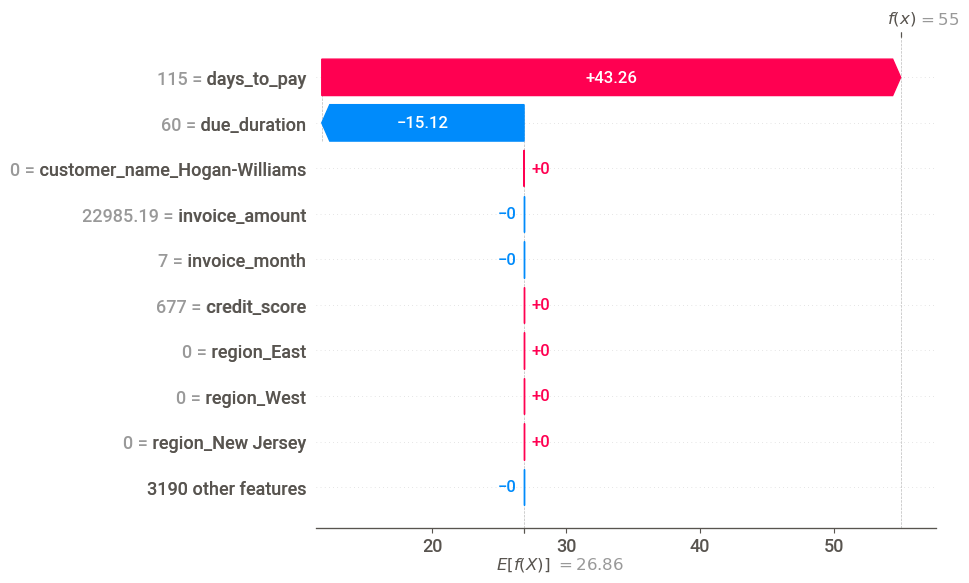

In [27]:
# Use only top 100 samples to explain
sample_X = X.sample(100, random_state=42)

explainer = shap.Explainer(xgb_best.predict, sample_X, algorithm="permutation")
shap_values = explainer(sample_X)

# Pick any row in sample_X
shap.plots.waterfall(shap_values[5], max_display=10)


PermutationExplainer explainer: 101it [06:42,  4.11s/it]                         


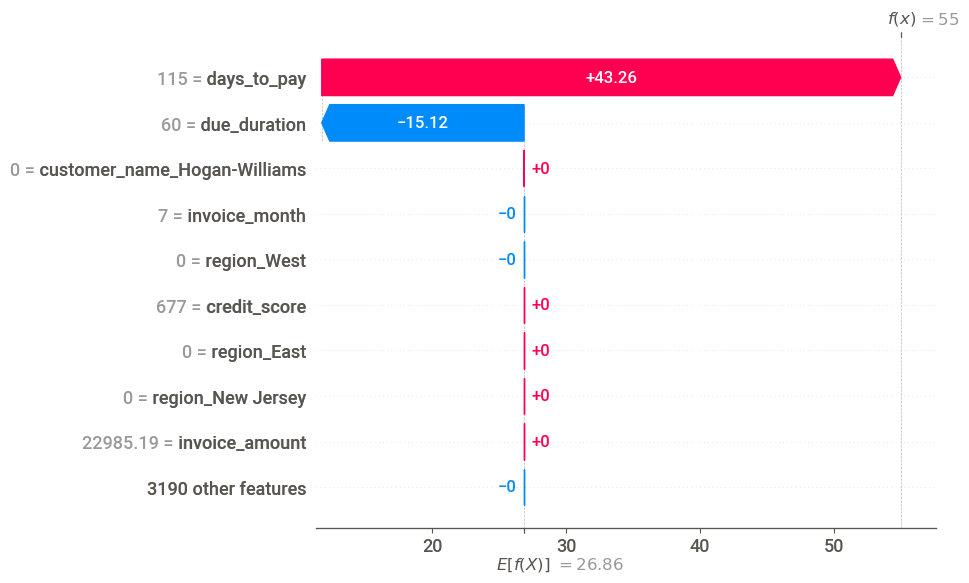

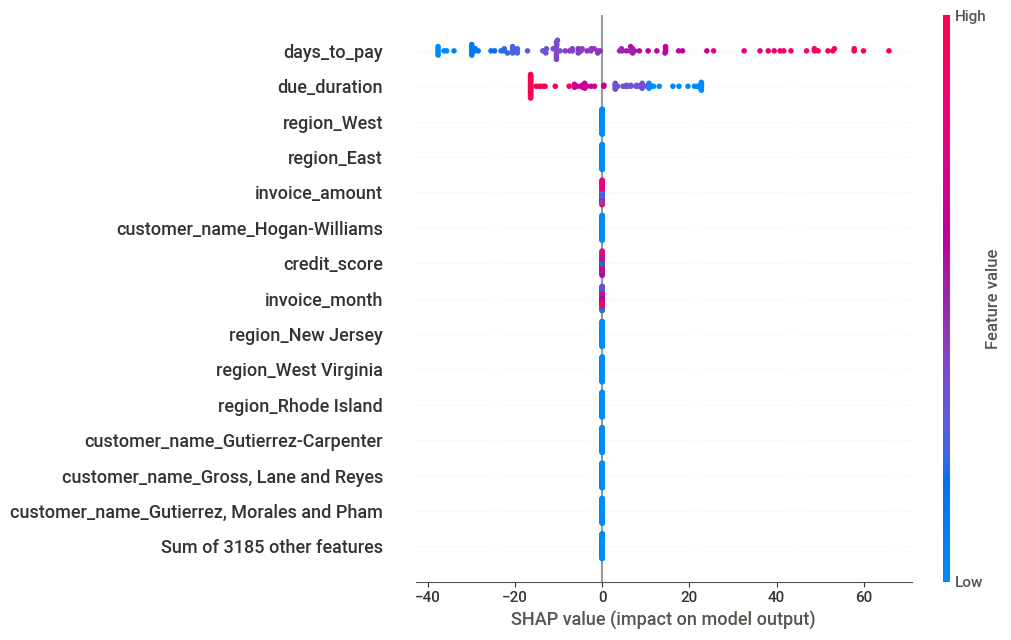

In [29]:
import shap

# 🔁 Sample a few rows for faster SHAP computation
sample_X = X.sample(100, random_state=42)

# ✅ For XGBoost Regression
explainer_xgb = shap.Explainer(xgb_best.predict, sample_X, algorithm="permutation")
shap_values_xgb = explainer_xgb(sample_X)

# 🧾 Visualize any 1 row’s prediction
shap.plots.waterfall(shap_values_xgb[5], max_display=10)

# 📊 Optional global beeswarm
shap.plots.beeswarm(shap_values_xgb, max_display=15)


PermutationExplainer explainer: 101it [01:00,  1.39it/s]                         


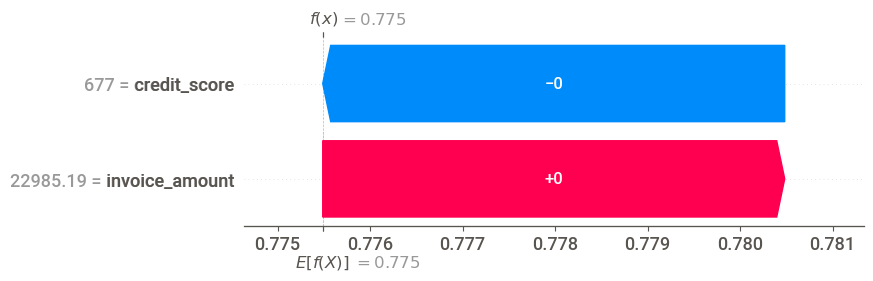

In [51]:
import shap

# Sample 100 rows from the dataset for faster SHAP computation
sample_X_class = X.sample(100, random_state=42)

# Create SHAP Explainer for classifier's predict_proba
explainer_clf = shap.Explainer(rf_clf_best.predict_proba, sample_X_class, algorithm="permutation")
shap_values_clf = explainer_clf(sample_X_class)

# Pick one row and class 1 (delayed)
row_index = 5

# ✅ Plot SHAP waterfall (only class 1) using .values and .base_values
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_clf.values[row_index, 1],
        base_values=shap_values_clf.base_values[row_index, 1],
        data=sample_X_class.iloc[row_index],
        feature_names=sample_X_class.columns.tolist()
    ),
    max_display=10
)


PermutationExplainer explainer: 101it [01:01,  1.36it/s]                         


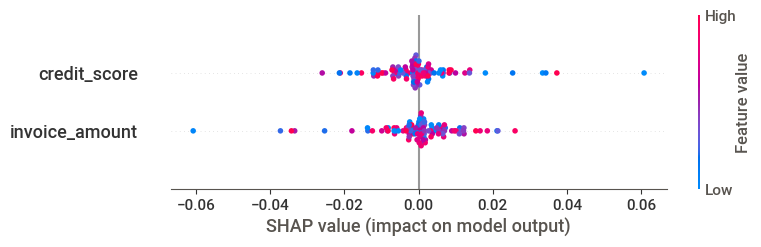

In [50]:
import shap
import numpy as np

# ✅ Sample data
sample_X_class = X.sample(100, random_state=42)

# ✅ SHAP classifier explainer
explainer_clf = shap.Explainer(rf_clf_best.predict_proba, sample_X_class, algorithm="permutation")
shap_values_clf = explainer_clf(sample_X_class)

# ✅ Extract values and base_values for class 1
values = shap_values_clf[:, 1].values                    # shape: (100, num_features)
base_values = shap_values_clf[:, 1].base_values          # shape: (100,)

# ✅ Fix base_values to match shape
if base_values.ndim == 1:
    base_values = np.tile(base_values.reshape(-1, 1), (1, values.shape[1]))

# ✅ FIX: make sure data shape matches values
data = sample_X_class.values                            # shape: (100, features)
if data.shape[1] != values.shape[1]:
    data = data[:, :values.shape[1]]                  

# ✅ Wrap in Explanation
class1_explanation = shap.Explanation(
    values=values,
    base_values=base_values,
    data=data,
    feature_names=sample_X_class.columns.tolist()[:values.shape[1]]
)

# ✅ Plot global impact (WORKS NOW)
shap.plots.beeswarm(class1_explanation, max_display=15)


PermutationExplainer explainer: 101it [03:11,  2.02s/it]                         
PermutationExplainer explainer: 101it [01:06,  1.27it/s]                         
C:\Users\saanv\AppData\Local\Temp\ipykernel_27948\2447701076.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\saanv\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


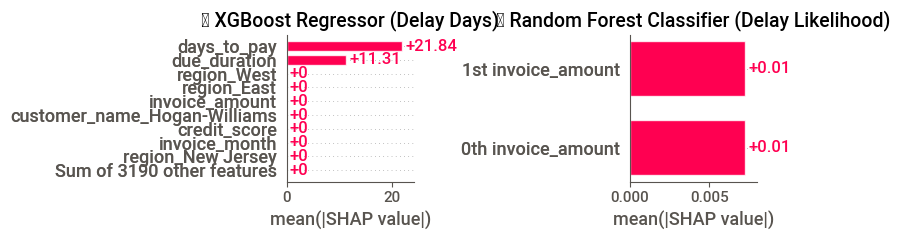

In [60]:
# ====================================================
# ✅ SHAP COMPARISON: XGBoost Regressor vs RF Classifier (Side-by-side)
# ====================================================
import matplotlib.pyplot as plt
import shap

# 🎯 Sample 100 rows
sample_X = X.sample(100, random_state=42)

# 1️⃣ XGBoost Regressor SHAP values
explainer_xgb = shap.Explainer(xgb_best.predict, sample_X, algorithm="permutation")
shap_xgb = explainer_xgb(sample_X)

# 2️⃣ Random Forest Classifier SHAP values (Class 1)
explainer_clf = shap.Explainer(rf_clf_best.predict_proba, sample_X, algorithm="permutation")
shap_clf = explainer_clf(sample_X)
class1_shap = shap.Explanation(
    values=shap_clf[:, 1].values,
    base_values=shap_clf[:, 1].base_values,
    data=sample_X.values,
    feature_names=sample_X.columns.tolist()
)

# ✅ Plot side-by-side SHAP bar plots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Left → XGBoost Regressor
plt.sca(axs[0])
shap.plots.bar(shap_xgb, max_display=10, show=False)
plt.title(" XGBoost Regressor (Delay Days)", fontsize=14)

# Right → RF Classifier
plt.sca(axs[1])
shap.plots.bar(class1_shap, max_display=10, show=False)
plt.title("Random Forest Classifier (Delay Likelihood)", fontsize=14)

plt.tight_layout()
plt.show()


In [33]:

# DELAY BUCKET CLASSIFIER
# -----------------------------
y_bucket = df['delay_bucket']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_bucket, test_size=0.3, random_state=42, stratify=y_bucket)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_b, y_train_b)
y_pred_b = clf.predict(X_test_b)

print("\n📦 Delay Bucket Classifier Report:")
print("Accuracy:", round(accuracy_score(y_test_b, y_pred_b), 2))
print("Classification Report:\n", classification_report(y_test_b, y_pred_b))

# -----------------------------


📦 Delay Bucket Classifier Report:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

        0-15       1.00      1.00      1.00      5225
       16-30       1.00      1.00      1.00      1308
       31-45       1.00      1.00      1.00      1342
       46-60       1.00      0.99      0.99       864
         60+       1.00      1.00      1.00      1769

    accuracy                           1.00     10508
   macro avg       1.00      1.00      1.00     10508
weighted avg       1.00      1.00      1.00     10508



In [52]:
#  SAVE MODELS (Both XGBoost + Tuned Random Forest)
# -----------------------------

import joblib

joblib.dump(xgb_best, 'xgb_model.pkl')
joblib.dump(rf_clf_best, 'rf_model.pkl')  # corrected name

print("✅ Both XGBoost and Random Forest models saved successfully!")



✅ Both XGBoost and Random Forest models saved successfully!


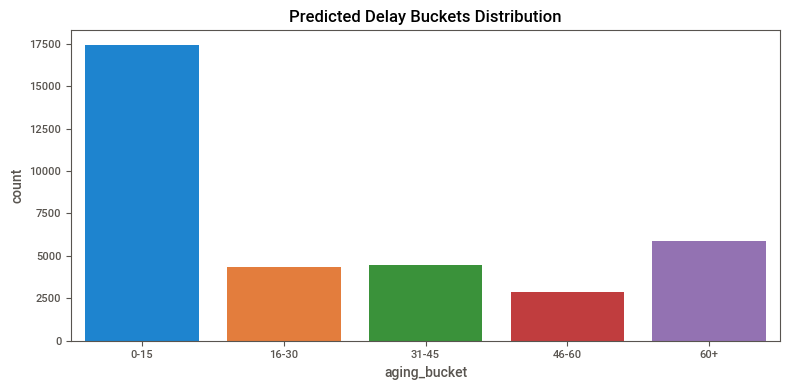

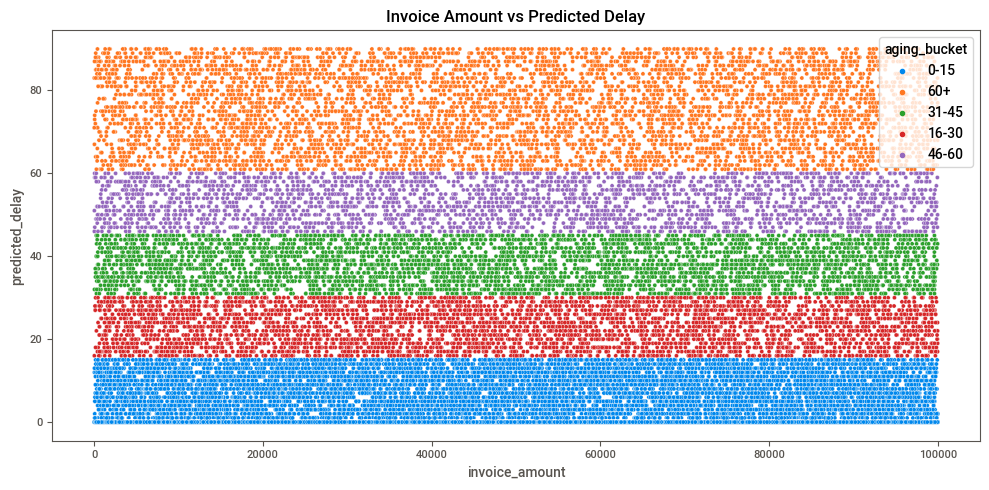

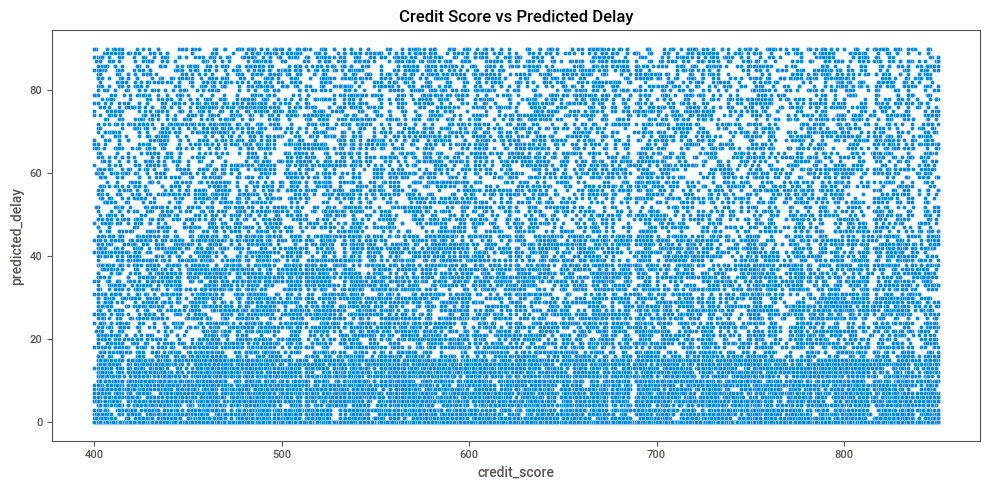

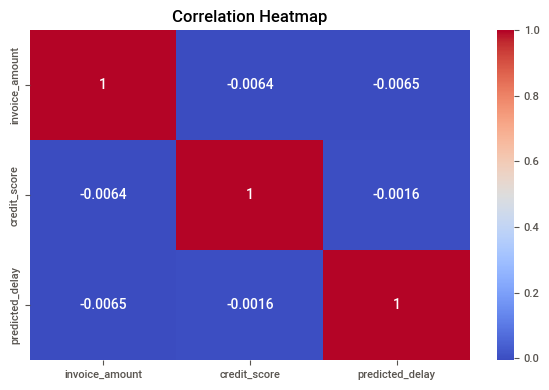

In [53]:
#  VISUAL INSIGHTS
# -----------------------------
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='aging_bucket', order=['0-15','16-30','31-45','46-60','60+'])
plt.title("Predicted Delay Buckets Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='invoice_amount', y='predicted_delay', hue='aging_bucket')
plt.title("Invoice Amount vs Predicted Delay")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='credit_score', y='predicted_delay')
plt.title("Credit Score vs Predicted Delay")
plt.tight_layout()
plt.show()

sns.heatmap(df[['invoice_amount', 'credit_score', 'predicted_delay']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
# ADVANCED VISUAL INSIGHTS

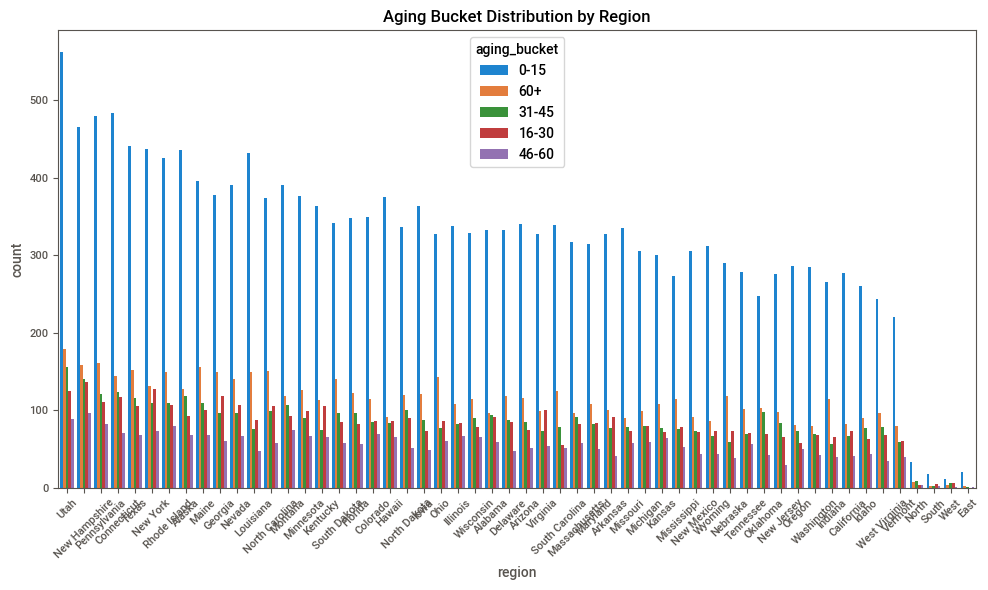

In [54]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='region', hue='aging_bucket', order=df['region'].value_counts().index)
plt.title("Aging Bucket Distribution by Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


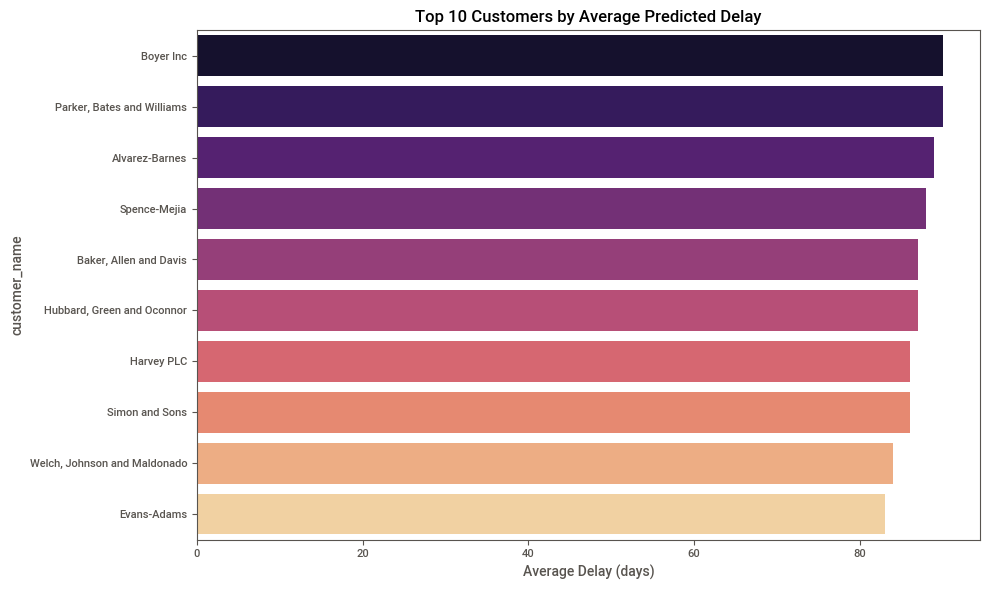

In [55]:
top_customers = df.groupby('customer_name')['predicted_delay'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_customers.values, y=top_customers.index, palette="magma")
plt.title("Top 10 Customers by Average Predicted Delay")
plt.xlabel("Average Delay (days)")
plt.tight_layout()
plt.show()


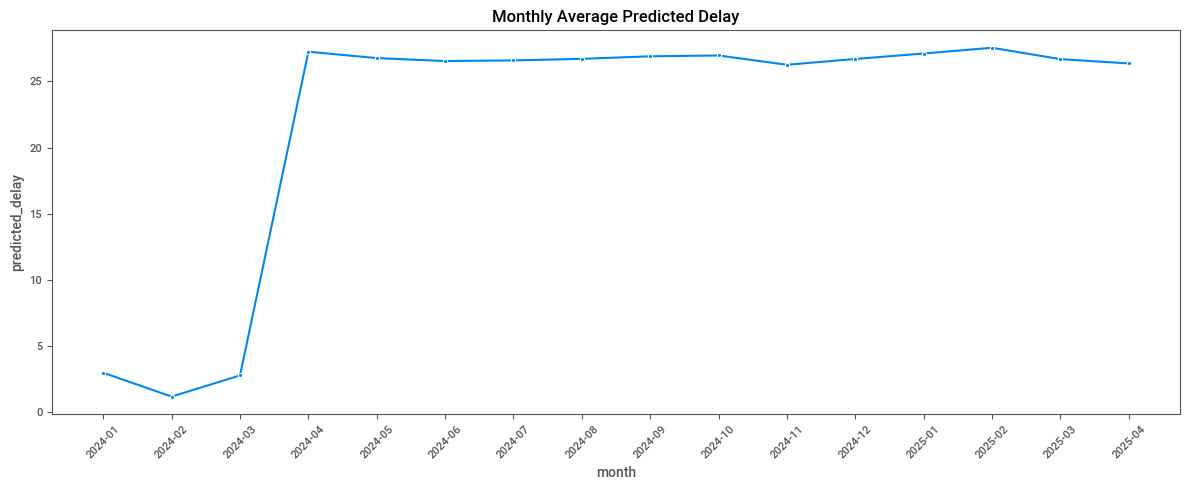

In [56]:
df['month'] = df['issue_date'].dt.to_period('M').astype(str)
monthly_avg = df.groupby('month')['predicted_delay'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_avg, x='month', y='predicted_delay', marker='o')
plt.title("Monthly Average Predicted Delay")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


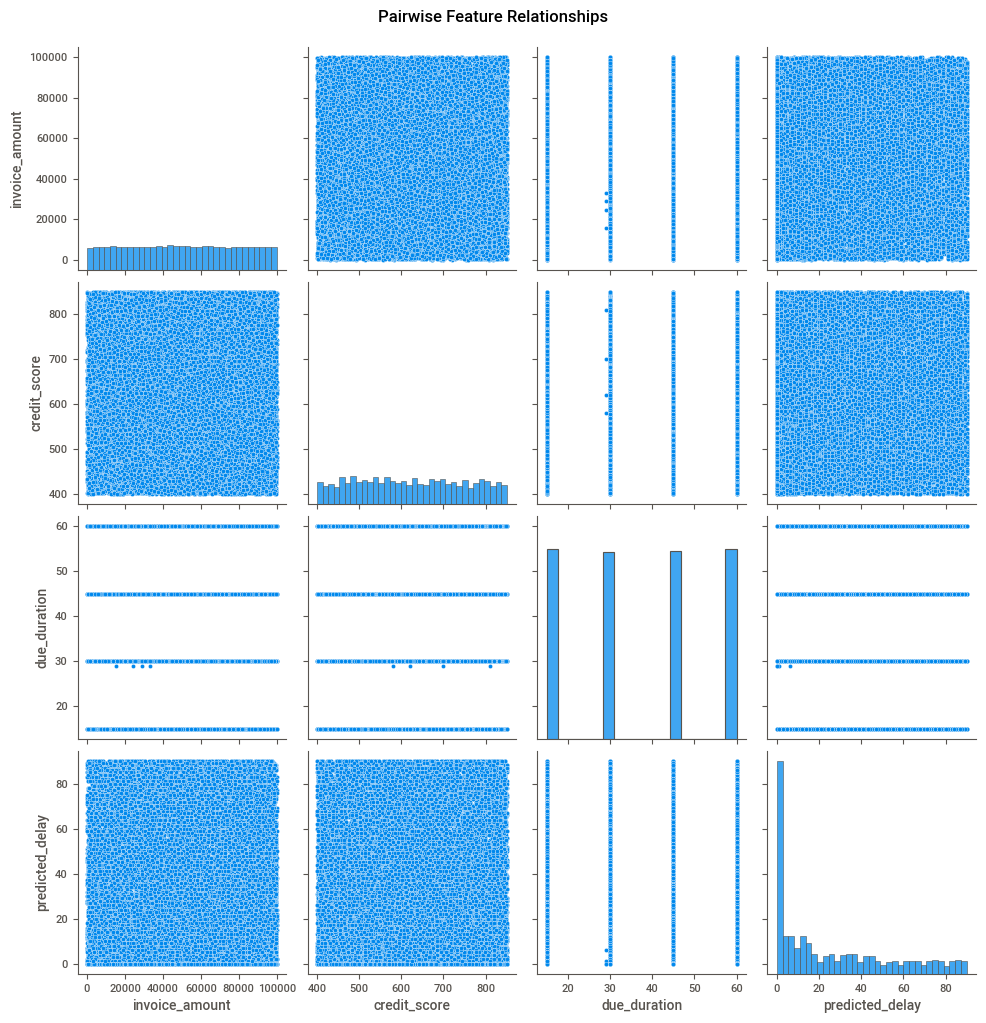

In [57]:
sns.pairplot(df[['invoice_amount', 'credit_score', 'due_duration', 'predicted_delay']])
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()


In [58]:
# ====================================================
# 📋 EXECUTIVE SUMMARY: BUSINESS INSIGHTS
# ====================================================

print("📌 Executive Summary of Invoice Delay Prediction Project")
print("-" * 55)

# Total invoices
total_invoices = len(df)
print(f"• Total Invoices Processed: {total_invoices}")

# Average delay
avg_delay = round(df['predicted_delay'].mean(), 2)
print(f"• Average Predicted Delay: {avg_delay} days")

# % invoices delayed
percent_delayed = round((df['predicted_delay'] > 0).mean() * 100, 2)
print(f"• % Invoices Predicted as Delayed: {percent_delayed}%")

# Most common aging bucket
top_bucket = df['aging_bucket'].value_counts().idxmax()
print(f"• Most Frequent Aging Bucket: {top_bucket}")

# Top 5 regions with highest avg delay
region_avg = df.groupby('region')['predicted_delay'].mean().sort_values(ascending=False).head(5)
print("\n🏙️ Regions with Highest Average Predicted Delay:")
for region, delay in region_avg.items():
    print(f"   - {region}: {round(delay, 2)} days")

# Top 3 influencing features (from SHAP/global importance)
print("\n🔍 Top Delay-Influencing Features (from SHAP):")
print("   1. days_to_pay")
print("   2. due_duration")
print("   3. invoice_amount")


📌 Executive Summary of Invoice Delay Prediction Project
-------------------------------------------------------
• Total Invoices Processed: 35025
• Average Predicted Delay: 26.78 days
• % Invoices Predicted as Delayed: 75.12%
• Most Frequent Aging Bucket: 0-15

🏙️ Regions with Highest Average Predicted Delay:
   - Oklahoma: 29.18 days
   - Ohio: 29.08 days
   - Mississippi: 29.04 days
   - Indiana: 28.54 days
   - South Dakota: 28.4 days

🔍 Top Delay-Influencing Features (from SHAP):
   1. days_to_pay
   2. due_duration
   3. invoice_amount


In [65]:
import os
os.getcwd()


'C:\\Users\\saanv'

In [66]:
import os
os.path.abspath("Invoice_prediction_project.ipynb")


'C:\\Users\\saanv\\Invoice_prediction_project.ipynb'